# Project 4: Searching for and fitting periodic signals in radial-velocity data

### Assignment for ASTM29 Statistical Tools in Astrophysics
### PJM 2022/AJM 2024

## Jupyter notebook

As for Project 2, for this Project you are provided with a skeleton Jupyter notebook. You should complete this, provide commentary in markdown cells, and submit the completed notebook for evaluation, instead of a pdf report.

The project is described below. I also leave spaces for you to complete some of the work.

This takes the place of a written report. This Jupyter notebook should be completed by each student with code that does the tasks required and produces the required plots (either within the notebook or saved as files).

**You are welcome to discuss the project amongst yourselves and help each other to some extent. However, the work handed in should be your own: code written yourselves and the write-up in your own words.**

There is no need to re-write the elements of the method's section that are given, but details should be given where necessary to explain what the code is doing (preferably in the form of Markdown cells). Otherwise the assessment will be on similar grounds to those in other projects, e.g., clarity of diagrams, good readable code. Treat the notebook you hand in roughly as you would do a report, i.e., remove any rough work or unused code.

It is important that your notebook runs properly for the person marking it. Make sure this is the case by checking with "restart kernel and run all cells", and and only using relative paths to files $^{\bf 1}$.


In [1]:
# put your module imports here

import numpy as np
import matplotlib.pyplot as plt
import astropy 
from tqdm import tqdm
import os
import glob 
from astropy.timeseries import LombScargle , BoxLeastSquares
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

## Background

Many astronomical signals are periodic, for example the magnitude of a 
variable star, X-ray emission from a pulsar, or the radial velocity of
a spectroscopic binary. A *time series* is a sequence of observations 
$(t_j,h_j)$, where $t_j$ is the time of the $j$ th observation and $h_j$ the
measured quantity at that time (e.g., magnitude, intensity, radial velocity).
A common problem is to discover and characterize periodicity in a time
series, for example to determine the period (or frequency) of the variations.
 
If the times $t_j$ are equidistant ($t_{j+1}=t_j+\Delta t$, where $\Delta t$
is constant) the time series is *evenly sampled*, and the discrete Fourier 
transform provides a simple and efficient way to find any periodicity and
determine its period.

However, in astronomy the time series is very often *unevenly sampled*,
and the standard Fourier technique cannot be used. A basic tool is then the
so-called Lomb–Scargle periodogram, which indicates the possibility of
different periodicities as function of frequency.

This project has two parts:

**1) Search for periodic signals**

In this project we will apply the Lomb–Scargle periodogram method to
three different time series, which are radial-velocity measurements of
the stars HD142, HD27442, and HD102117, obtained as part of the 
Anglo-Australian Planet Search programme at the Siding Spring Observatory 
in New South Wales $^{\bf 2,3,4}$. 

Planetary companions were detected around all three
planets by means of these data, and your first task is to estimate the period of these signals, 
and estimate the probability that they are real.

The Lomb-Scargle periodogram method for doing this is described in Ivezić et al.$^{\bf5}$
and during lectures. Further information can be found in VanderPlas $^{\bf6}$.

For this, it is recommended that you use the Astropy implementation of the Lomb-Scargle periodogram, 
as coding up the equations yourself can be cumbersome and prone to typos. Documentation for this
can be found here: https://docs.astropy.org/en/stable/timeseries/lombscargle.html .

**2) Fitting the periodic signal**

Once you have identified the dominant periodic signal, its period and amplitude, from
the LS periodogram, use this as the starting point for a nonlinear least-squares 
fit of the planet's orbital properties: period, eccentricity, argument of 
perihelion (the direction the ellipse points in space), and $M\sin i$.


#### Footnotes


$^{\bf 1}$ Relative paths are names of files etc. relative to the directory the code is run in. Your code should, for example, read a file named as  'filename.csv' or 'data/filename.csv', not '/Users/myname/code/ASTM29/Project2/filename.csv'  

$^{\bf 2}$ Tinney et al., 2002, *Two Extrasolar Planets from the Anglo-Australian Planet Search*, ApJ 571, 528 

$^{\bf 3}$  Butler et al., 2001, *Two New Planets from the Anglo-Australian Planet Search*, ApJ 555, 410

$^{\bf 4}$ Tinney et al., 2005, *Three Low-Mass Planets from the Anglo-Australian Planet Search*, ApJ 623, 1171

$^{\bf 5}$ Ivezić et al, 2014, *Statistics, Data Mining, and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of Survey Data*, Princeton University Press

$^{\bf 6}$ VanderPlas, 2018, *Understanding the Lomb-Scargle Periodogram*, ApJS 236, 16




# Student's work
## N.B. Below this point you need to start filling in code & text where prompted

## 1) Finding periodic signals 

The three data files each contain a list of measured radial velocities for the star identified by the name of the file. Data can be retrieved from the course web page.

The three columns are
1. The date of observations in days (from some arbitrary origin) 
2. The measured heliocentric radial velocity in units $ms^{-1}$
3. The estimated uncertainty of the radial velocity in units $ms^{-1}$

Read in these data. Plot them and see if you see anything by eye.

In [2]:
current_dir = os.getcwd()
folder = '/P4data'
data_dir = current_dir + folder
change_dir = os.chdir(data_dir)

In [3]:
txt_files = glob.glob('*.txt')

stars = {}

# Put each star into a dictionary as an AstoPy table
for file in txt_files:
    key = file.split('.')[0]  # Use the filename without extension as the key
    #reading the table into the dictionary
    stars[key.upper()] = astropy.table.Table.read(file, format='ascii', names=['Time', 'Radial Velocity', 'Uncertainty'])
    #create the units of the individual columns
    stars[key.upper()]['Time'].unit = astropy.units.day
    stars[key.upper()]['Radial Velocity'].unit = astropy.units.m/astropy.units.s
    stars[key.upper()]['Uncertainty'].unit = astropy.units.m/astropy.units.s


### For each star:
    
Consider what the lowest and highest useful frequencies 
($f_\text{min}$ and $f_\text{max}$) might be, as well as the frequency resolution ($\Delta f$) required
in order not to miss any maximum. See Ivezić et al. for a discussion of appropriate values. Note that
Astropy's LS implementation can choose suitable frequencies itself. Explore some different 
frequency vectors and see whether Astropy's choice was adequate.

Then compute and plot $P(f)$
for $f=f_\text{min}+\Delta f,\,f_\text{min}+2\Delta f,\,\dots,\,f_\text{max}$ for your various sets
of frequencies.

The Lomb-Scargle model is writen as $RV_{LS}(t; f, \vec{\theta}) = \theta_0 + \sum_{n=1}^{\tt M} [\theta_{2n-1}\sin(2\pi n f t) + \theta_{2n}\cos(2\pi n f t)]$ where $\vec{\theta}$ is the vector of parameters for a given frequency. Using the assumption that there is only one planet orbiting the star, M can be set to be unitary. However this is not true in reality since there can be more than one exoplanet in a solar system.



In [4]:
def frequncy_range(star,number_of_steps=1000):# This function will return the frequency range of the observed data
    f_min = 1/(max(star['Time']) - min(star['Time'])) 
    f_max = 0.5/np.nanmedian([star['Time'][i] - star['Time'][i-1] for i in range(1, len(star['Time']))])
    delta_f_step_size = (f_max - f_min)/number_of_steps
    day=astropy.units.day
    return f_min/day, f_max/day, delta_f_step_size/day# Not angular frequency

Below I calculate the power spectrum $P(f)$. For different values of $\Delta f$, I get different peak resolution. The smallest spacing of 10 between $f_min$ and $f_max$ does not recreate the maximums properly. For smaller bin sizes, there is higher resolution of the peaks. However This is not often ideal since it will create instablilities in power spectra for higher values of $M>1$. Recognizing the periodicity by eye was not possible due to the uneven spaced observation. 


337.5
0.2726100689021913
174.49999999999997
0.32012702432673673
462.49999999999994
0.11212621294576214


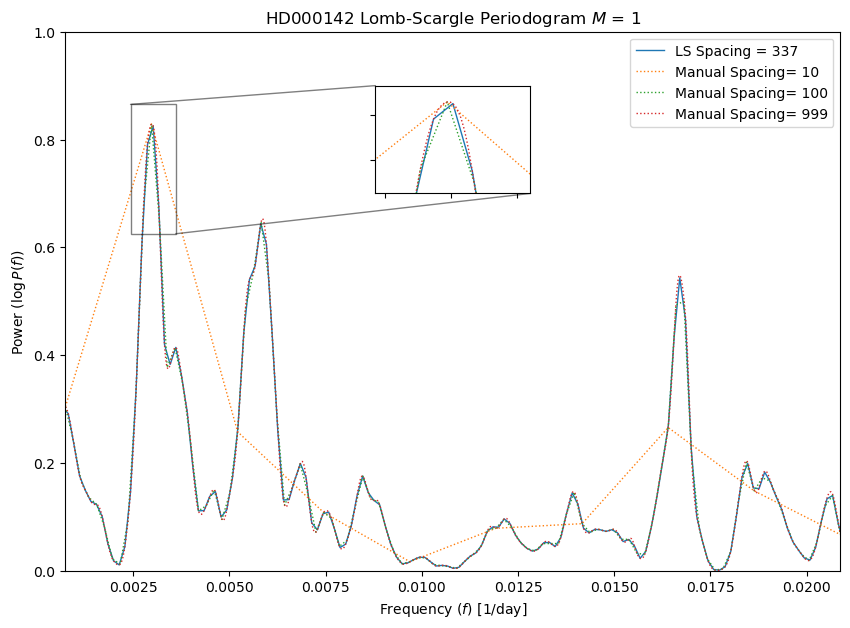

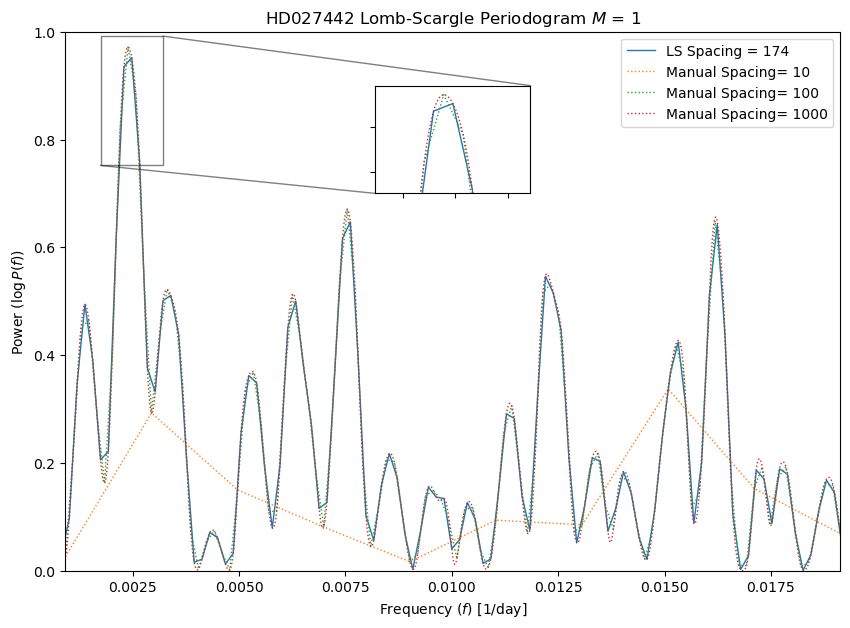

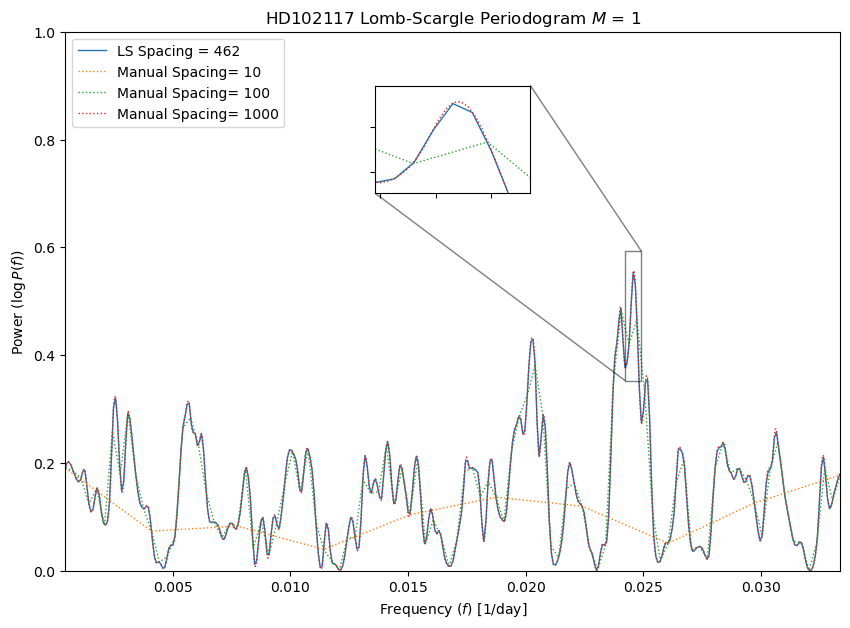

In [32]:
for terms in np.array([1]): #loop over the number of terms in the Lomb-Scargle model and to see the effects of it
    for star in stars.keys():
        fig=plt.figure(figsize=(10,7))
        ax=fig.add_subplot(111)
        # Create a Lomb-Scargle periodogram
        LS=LombScargle(stars[star]['Time'], stars[star]['Radial Velocity'], stars[star]['Uncertainty'],nterms =terms)

        auto_frequency = LS.autofrequency()

        # Compute the periodogram for automatic frequencies from Lomb-Scargle object's autofrequency method
        automatic_periodogram = LS.power(auto_frequency)
        print(auto_frequency[-1]/(auto_frequency[1]-auto_frequency[0]))
        auto_frequency = auto_frequency.value
        diff=(auto_frequency[1]-auto_frequency[0])

        ax.plot(auto_frequency, automatic_periodogram, label=r'LS Spacing = ' + f'{(auto_frequency[-1]-auto_frequency[0])/(auto_frequency[1]-auto_frequency[0]):.0f}',linewidth=1)
        ax.set_xlabel(r'Frequency ($f$) [1/day]')
        ax.set_ylabel(r'Power ($\log{P(f)}$)')
        ax.set_title(f'{star} Lomb-Scargle Periodogram $M$ = {terms}')

        ax.set_ylim(0,1)

        #make a zoom in of the peak
        print(automatic_periodogram[0])
        
        x1, x2, = auto_frequency[auto_frequency>0.001][np.argmax(automatic_periodogram[auto_frequency>0.001])]-diff*4, auto_frequency[auto_frequency>0.001][np.argmax(automatic_periodogram[auto_frequency>0.001])]+diff*4
        y1, y2 = automatic_periodogram[auto_frequency>0.001][np.argmax(automatic_periodogram[auto_frequency>0.001])]-0.2, automatic_periodogram[auto_frequency>0.001][np.argmax(automatic_periodogram[auto_frequency>0.001])]+0.04
        axins = ax.inset_axes( [0.4, 0.7, 0.2, 0.2], xlim=(x1, x2), ylim=(y1, y2),xticklabels=[], yticklabels=[])
        axins.plot(auto_frequency, automatic_periodogram,linewidth=1)
        for i in np.array([10,100,1000]): #loop over the number of steps in the manual spacing
            f_min, f_max, delta_f_step_size = frequncy_range(stars[star], number_of_steps=i)
            manual_frequencies = np.linspace(f_min, f_max, int((f_max - f_min)/delta_f_step_size))
            manual_periodogram = LS.power(manual_frequencies)
            ax.plot(manual_frequencies, manual_periodogram, linestyle=':',linewidth=1,label=r'Manual Spacing= ' + f'{int((f_max - f_min)/delta_f_step_size):.0f}')
            axins.plot(manual_frequencies, manual_periodogram, linestyle=':',linewidth=1)

        ax.set_xlim(f_min.value, f_max.value)

        ax.legend()

        ax.indicate_inset_zoom(axins, edgecolor="black")
    

Below I use the peak of the power spectra's freqency $f_o$ from above plots to determine the phase folding. 

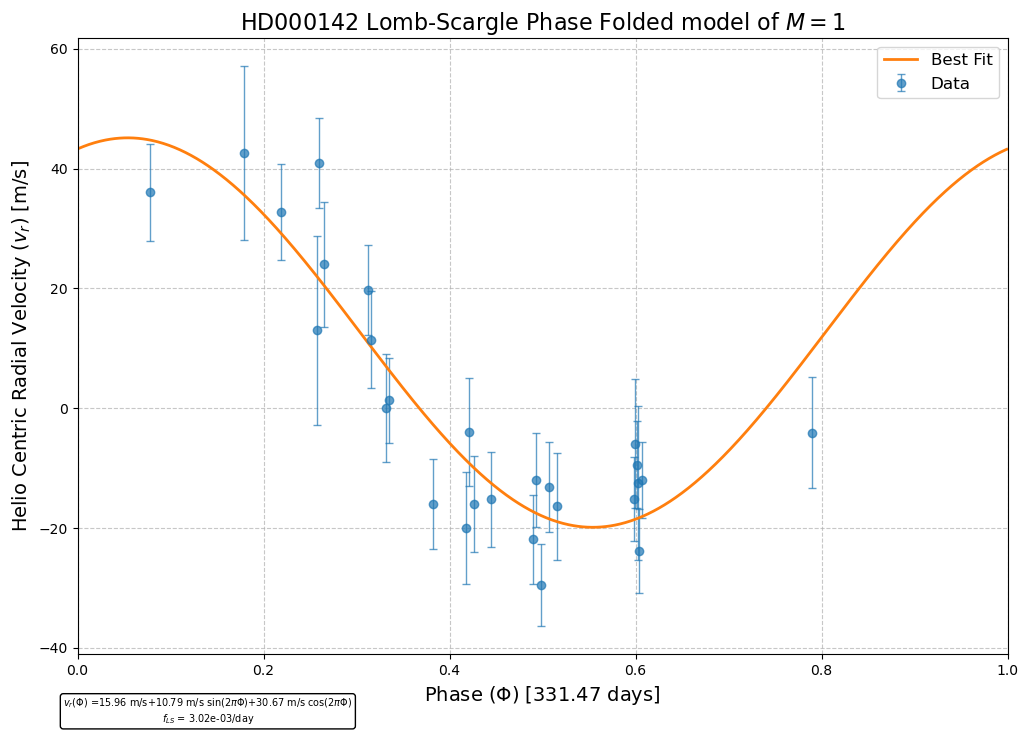

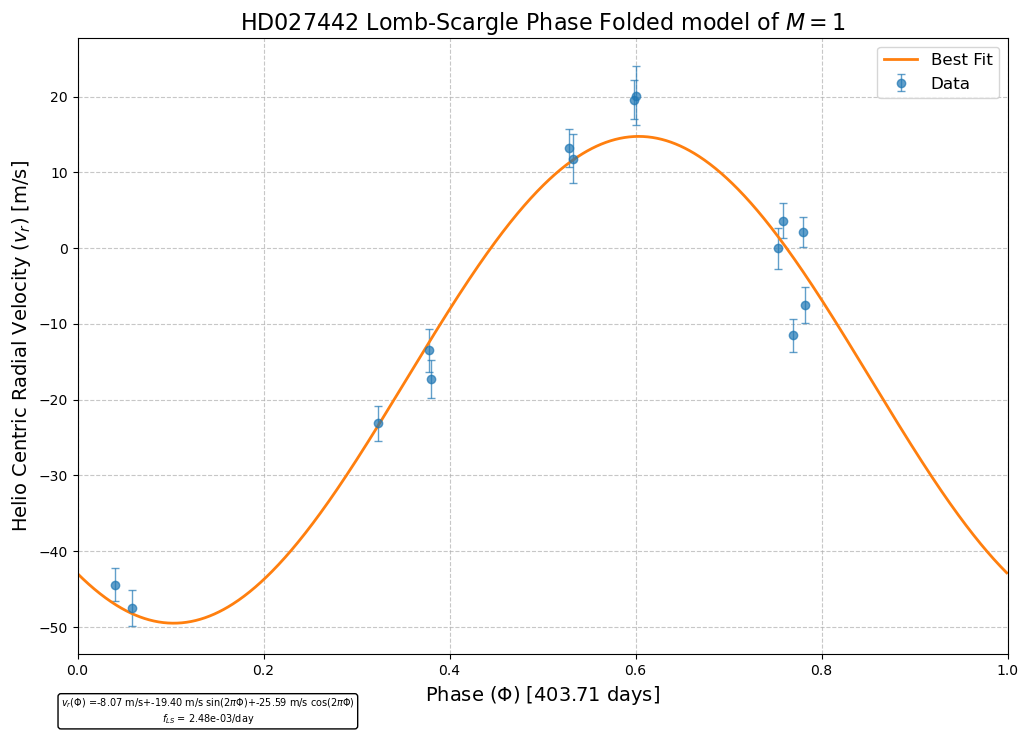

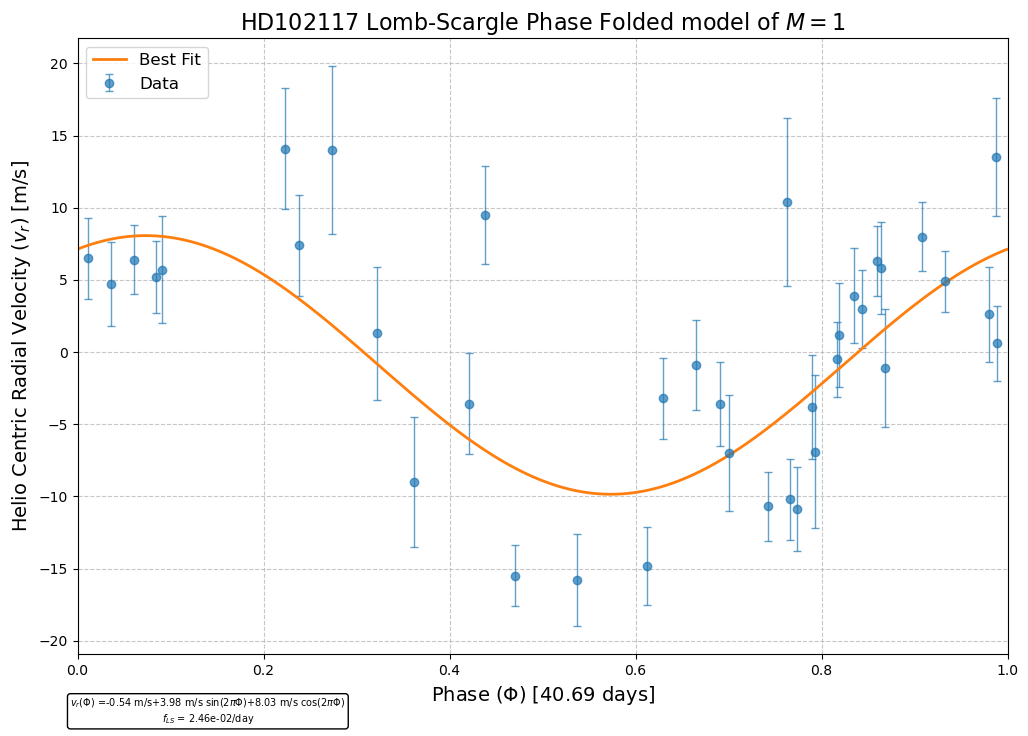

In [6]:
for star in stars.keys():
    # Create a Lomb-Scargle periodogram
    if star == 'HD102117': #wanted to try fitting M=3 here. The N here is actualy M.
        N=1
        LS = LombScargle(stars[star]['Time'], stars[star]['Radial Velocity'], stars[star]['Uncertainty'],nterms=N)
    else:
        N=1
        LS = LombScargle(stars[star]['Time'], stars[star]['Radial Velocity'], stars[star]['Uncertainty'],nterms=N)

    auto_frequency = LS.autofrequency()
    automatic_periodogram = LS.power(auto_frequency)
    # Calculate the best frequency and period
    best_frquency = auto_frequency[np.argmax(automatic_periodogram)] 
    best_period = 1 / best_frquency
    
    # Calculate the phase (not in angle)
    phase = (stars[star]['Time'] % best_period) / best_period 

    Phase = np.arange(0, 1, 0.001) * best_period 
    # Best fit model
    y_best_frquency = LS.model(Phase, best_frquency)
    best_frquency = best_frquency.to(1/astropy.units.day)  # Convert frequency to 1/day
    theta = LS.model_parameters(best_frquency).value
    # Plot the data and the best fit model
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.errorbar(phase, stars[star]['Radial Velocity'], yerr=stars[star]['Uncertainty'], fmt='o', elinewidth=1, capsize=3, label='Data', color='tab:blue', alpha=0.7)
    ax1.plot(Phase / best_period, y_best_frquency, label='Best Fit', color='tab:orange', linewidth=2)  # Normalize Phase for plotting
    ax1.annotate(r'$v_r(\Phi)$ ='+f'{theta[0]:.2f} m/s' + f'+{theta[1]:.2f} m/s '+r'$\sin(2\pi\Phi)$' + f'+{theta[2]:.2f} m/s '+r'$\cos(2\pi\Phi)$'+'\n'+r'$f_{LS}$'+f' = {best_frquency.value:.2e}/day', xy=(0.14, -0.11), xycoords='axes fraction', ha='center', fontsize=7, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    ax1.set_xlabel(r'Phase ($\Phi$) '+f'[{best_period.value:.2f} days]', fontsize=14)
    # ax1.annotate(f'Best Frequency = {best_frquency:.4f}', xy=(0.1, -0.2), xycoords='axes fraction', ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    ax1.set_ylabel(r'Helio Centric Radial Velocity ($v_r$) [m/s]', fontsize=14)
    ax1.set_title(f'{star} Lomb-Scargle Phase Folded model of $M=${N}', fontsize=16)
    ax1.set_xlim(0, 1)
    
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    plt.show()


    
    
    

Aside from HD102117, The other plots tend to generally show a good fit to the data, however the spread of HD102117 makes it hard to determine if it is a good fit. 

### For each star:

Using the bootstrap approach described by Ivezic et al., estimate the threshold values for 
$5\%$ and $1\%$ False Alarm Probability (FAP). 

This method requires you to keep the times of observations $t_j$ fixed, and draw values $h_j$ from the observed values (and the  uncertainty $\sigma_j$ associated with that observation) with replacement, and calculate the maximum value of the periodogram for this bootstrap sample. The $(100-X)\%$ percentile of these values corresponds to the $X\%$ FAP. 

Create a sufficiently large number of bootstrap samples that the FAP values you derive from this sample are reasonably accurate.
Note whether the discovery of a planet 
passes the 5% and 1% thresholds.

(Note: Astropy's Lomb–Scargle implementation contains routines that will calculate the FAP via bootstrapping and other methods. You *may* use this to check your results, but please implement and run your own bootstrapping method here.)

In [7]:
#Below I bootstrap to measure the FAP. All the data points tend to be below the 1% threshold and can be accepted as True. 
number_of_bootstrap_samples = 10000

Bootstrap={} #dictionary to store the maximum power of the periodogram for each bootstrap sample
for star in stars:
    P_max = []
    
    for _ in tqdm(range(number_of_bootstrap_samples)):
        index=np.random.randint(0,len(stars[star]['Time']),size=len(stars[star]['Time']))
        Time=stars[star]['Time']
        Radial_Velocity=stars[star]['Radial Velocity'][index]
        Uncertainty=stars[star]['Uncertainty'][index]
        
        LS_sample = LombScargle(Time, Radial_Velocity,Uncertainty,nterms=1)
        
        auto_frequency = LS_sample.autofrequency()
        automatic_periodogram = LS_sample.power(auto_frequency)
        # Calculate the best frequency and period
        best_frquency = auto_frequency[np.argmax(automatic_periodogram)]  #measure the best frequency 
        P_max.append(automatic_periodogram.max())#append the maximum power of the periodogram
        
    Bootstrap[star]=P_max
    
    


100%|██████████| 10000/10000 [00:09<00:00, 1065.34it/s]


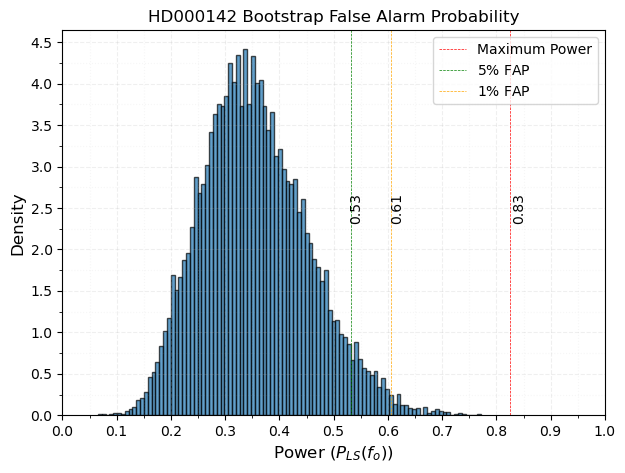

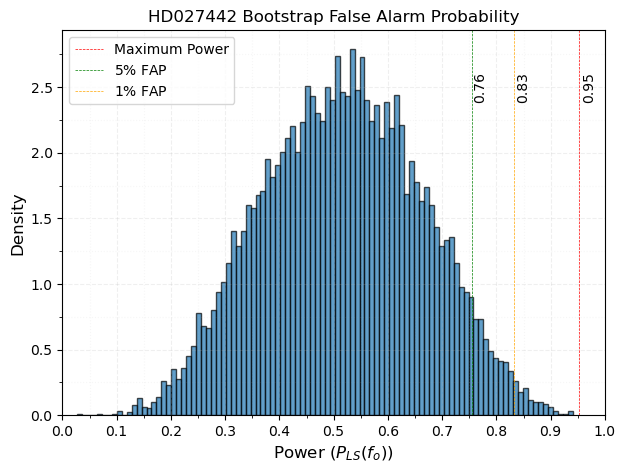

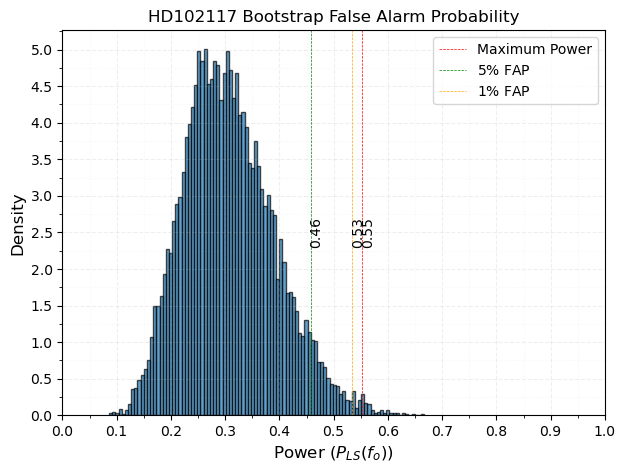

In [8]:
for star in stars: #plotting the FAP
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))
    ax.grid(True, linestyle='--', alpha=0.2)
    ax.grid(True, which='minor', linestyle=':', alpha=0.1)
    ax.hist(Bootstrap[star], bins=100, density=True, alpha=0.7, color='tab:blue', edgecolor='black', linewidth=1)
    ax.set_xlabel(r'Power ($P_{LS}(f_o)$)' ,fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'{star} Bootstrap False Alarm Probability')
    ax.set_xlim(0, 1)
    original_LS = LombScargle(stars[star]['Time'], stars[star]['Radial Velocity'], stars[star]['Uncertainty'],nterms=1)
    value_power = original_LS.power(original_LS.autofrequency()).max()
    ax.axvline(value_power, ymin=0, ymax=1, color='red', linestyle='--',lw=0.5, label='Maximum Power')
    ax.text(value_power*1.02, 2.5, f'{value_power:.2f}', fontsize=10, ha='center', va='center', rotation=90)
    ax.axvline(np.percentile(Bootstrap[star], 95),ymin=0,ymax=1, color='green', linestyle='--',lw=0.5, label=r'$5\%$ FAP')
    ax.text(np.percentile(Bootstrap[star], 95)*1.02, 2.5, f'{np.percentile(Bootstrap[star], 95):.2f}', fontsize=10, ha='center', va='center', rotation=90)
    ax.axvline(np.percentile(Bootstrap[star], 99),ymin=0,ymax=1, color='orange', linestyle='--',lw=0.5, label=r'$1\%$ FAP')
    ax.text(np.percentile(Bootstrap[star], 99)*1.02, 2.5, f'{np.percentile(Bootstrap[star], 99):.2f}', fontsize=10, ha='center', va='center', rotation=90)

    ax.legend()
    plt.show()

## 2) Fitting planetary orbits

You have now (hopefully) found a statistically significant periodic signal in the RV time-series 
for at least one star. Let us assume that this signal arises from the orbit of an unseen planet. 
(In practice, one needs to be careful that the signal does not arise from other effects such
as stellar activity cycles.)

Planets in general do not orbit their stars on perfectly circular orbits, but have some 
orbtal *eccentricity* $e$, where $e=0$ for a perfectly circular orbit and $e\to1$ makes the 
orbit more elliptical. The point on the elliptical orbit closest to the star is known as 
the *periapsis* (a.k.a. *periapse, periastron,* or similar terms named after the central body).

An eccentric orbit needs an extra parameter to describe its orientation in space: we will 
use the *argument of periapsis* $\omega$, the angle between the point where the orbit cuts the 
plane of the sky and the periapsis itself. The point where the orbit cuts the plane of the sky 
lies on the *line of nodes,* which lies at an angle $\Omega$ (the *longitude of ascending
node*) from a fixed reference direction. The orbital plane is inclined at an angle 
$I$, the *orbital inclination,* to the plane of the sky (so that $I=0^\circ$ for
a face-on orbit and $I=90^\circ$ for an edge-on orbit.

Finally, we have the orbital period $P$ and the time at which the planet passes periapsis
$\tau$, the *time of periapsis passage*.

The six parameters $(\tau,\omega,\Omega,P,e,I)$ form a set of *orbital elements* that, 
in combination with the star's mass, precisely define the orbit. Other sets of orbital elements
are possible: for example, the period corresponds to the orbital *semimajor axis* $a$ via 
Kepler's Third Law. Some of these orbital elements are illustrated here. 
https://en.wikipedia.org/wiki/Orbital_elements#/media/File:Orbit1.svg

For a planet detected only by RV, we have no information about $I$ or $\Omega$ (why?). 
Hence we have four orbital elements to find: $(\tau,\omega,P,e)$, along with the 
planet:star mass ratio (usually fit as the amplitude of the RV signal, $K$), 
and the magnitude of the RV offset $V$.

The formula describing the measured radial velocity at a time $t_i$ is then
$v_i = V + K[\cos(\omega+f)+e\cos\omega]$,
where $f$ is the angle round the orbit measured from periapsis, called the 
*true anomaly*. Unfortunately, for non-circular orbits there is no 
closed-form solution for f as a function of time (whereas for a circular orbit,
it is a simple sinusoid).

A function to calculate f(t) is provided below, making use of an auxiliary angle 
known as the *eccentric anomaly* and denoted $E$. You need to feed it the *mean 
anomaly* $M = 2\pi(t-\tau)/P$, which is a measure of the orbital phase but 
increasing at a constant rate.

For further details, see, e.g., Chapter 2 of the Exoplanets Handbook by Perryman (CUP) https://www.cambridge.org/core/books/exoplanet-handbook/750759E015FDCF469D141F0046198519

Below image was taken from https://en.wikipedia.org/wiki/Orbital_elements#/media/File:Orbit1.svg

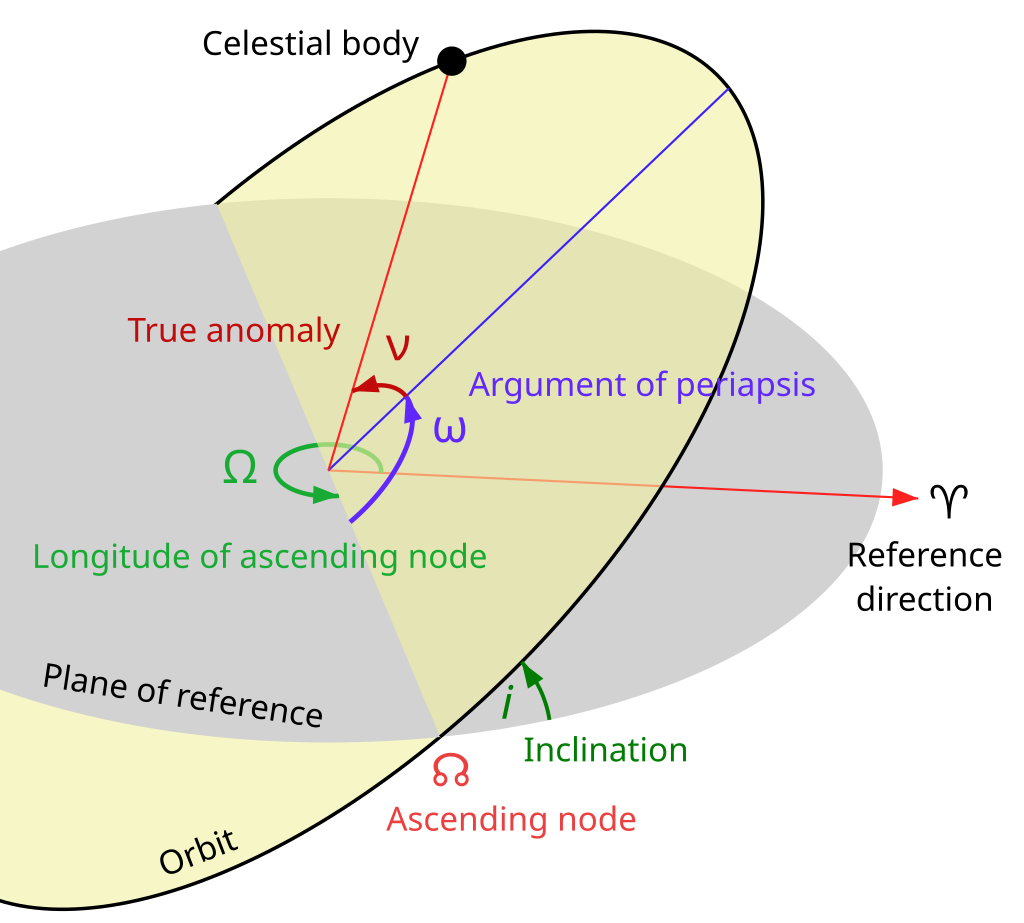

In [9]:
# Stellar masses for each star obtained from the respective papers. 
stellar_masses = {
    "HD000142": 1.21*astropy.units.M_sun,       # in units of solar mass M_sun
    "HD027442": 1.48*astropy.units.M_sun,
    "HD102117": 1.01*astropy.units.M_sun
}
#the Source papers are
# HD000142: 
# Tinney et al., 2002: ApJ 571, 528 
# http://adsabs.harvard.edu/abs/2002ApJ...571..528T 

# HD027442:
# Butler et al., 2001: ApJ 555, 410
# http://adsabs.harvard.edu/abs/2001ApJ...555..410B

# HD102117:
# Tinney et al., 2005: ApJ 623, 1171
# http://adsabs.harvard.edu/abs/2005ApJ...623.1171T


 As the name suggests, planet with only RV information it is not possible to measure the $I$ and $\Omega$ because RV only measures the projection of the true velocity RELATIVE to the reference direction. You would need the spacial orientation to find these parameters. Thats also why we only get minimum mass of the planet rather than the maximum. I am not an expert on exoplanets, But perhaps doing direct imaging if the planet happens to pass in front of the star. Then the path taken of the planet can be used to determine the orientation of the orbit. 

In [10]:
# solve Kepler's equation by Newton--Raphson iteration
# M can be a vector
# NB f and M are in radians!!!
# NB f will be returned in the range [0,2pi)
def f_from_M(M,e,iterations=8):
    nt = len(M)
    MM = np.mod(M,2*np.pi)
    # starting point for NR iterations
    if e >= 0.8:
        Ei = np.zeros(nt)+np.pi
    else:
        Ei = np.zeros(nt)

    for i in range(iterations+1):
        Ei = Ei - (Ei -e*np.sin(Ei) - MM)/(1 - e*np.cos(Ei))

    f = np.arctan2(np.sqrt(1-e**2)*np.sin(Ei),np.cos(Ei) - e)
    f = f + 2*np.pi*(f < 0)
    return f

def Keplerian_model(theta, t): #keplerian model.
    # theta = [K, P, e, omega, gamma, phi] is the parameter vector
    # t is time
    V,K,P,e,tau,omega = theta
    # calculate mean anomaly
    M = 2*np.pi*(t - tau)/P
    # calculate true anomaly
    f = f_from_M(M, e)
    # calculate radial velocity
    return K*(np.cos(f + omega) + e*np.cos(omega)) + V

Now choose one of the datasets and fit the six parameters $\vec{\theta}=(V,K,P,e,\tau,\omega)$
using a nonlinear least-squares routine (such as are available, *e.g.,* in SciPy).
You will need to minise the chi-squared function
$\chi^2(\vec{\theta})=\sum_i \frac{\left(v_i - v(t_i|\vec{\theta})\right)^2}{\sigma_i}$ 
where $v_i$ is the observed radial velocity at time $t_i$, $v(t_i|\vec{\theta})$
that predicted from the eccentric orbit model with parameters $\vec{\theta}$, 
and $\sigma_i$ the observational unceartainty.

Nonlinear optimisation routines often require a careful choice of 
initial guess for the parameters, to ensure fast convergence to the 
global extremum and to avoid getting stuck in a local extremum. Use
the results of your Lomb--Scargle periodogram to help you choose
a suitable initial guess for $\vec{\theta}$.

Remember to plot your best-fit curve along with the data: this can help 
verify that the optimisation routine hasn't got stuck in a local extremum.

Once you have your best-fit parameters, you can 
find the planetary $m\sin I$ using the formula
$K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{m\sin I}{M_\star^{2/3}} \frac{1}{\sqrt{1-e^2}}$

I choose to fit the all the data sets. 

Best-fit parameters:
V = 6.835531859804831
K = 29.93832230679157
P = 339.2773915374317
e = 0.3622477958470697
tau = 1414.6280874302001
omega = 1.2467727769475823
Msini = 1.09 jupiterMass


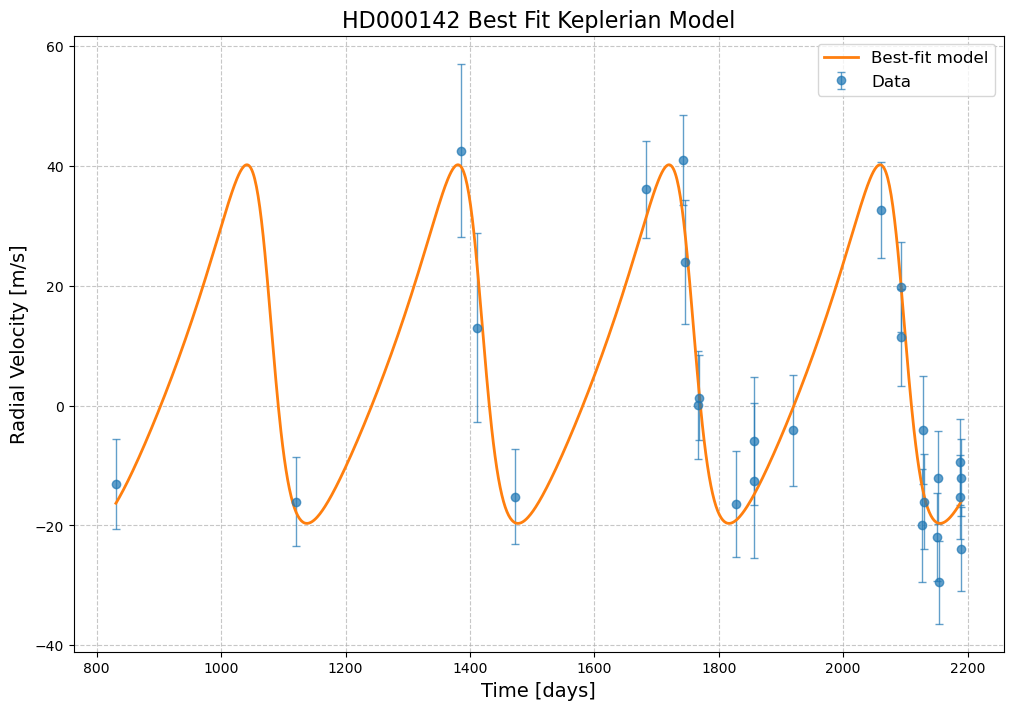

Best-fit parameters:
V = -15.771008386294616
K = 31.495109635944726
P = 415.03286953226336
e = 0.04686384626387597
tau = 1846.5347087294122
omega = -0.2999999999998711
Msini = 1.50 jupiterMass


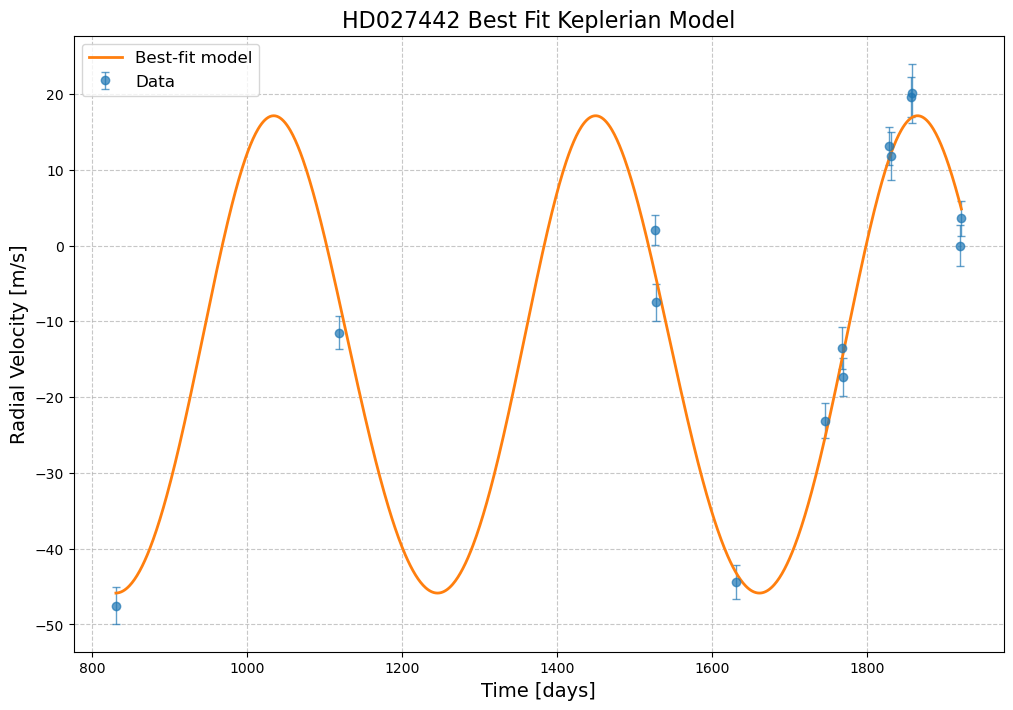

Best-fit parameters:
V = -0.742069576795848
K = 11.831037488236898
P = 40.672503846972624
e = 0.491303471532936
tau = 1729.6809276973895
omega = 2.494301775958078
Msini = 0.18 jupiterMass


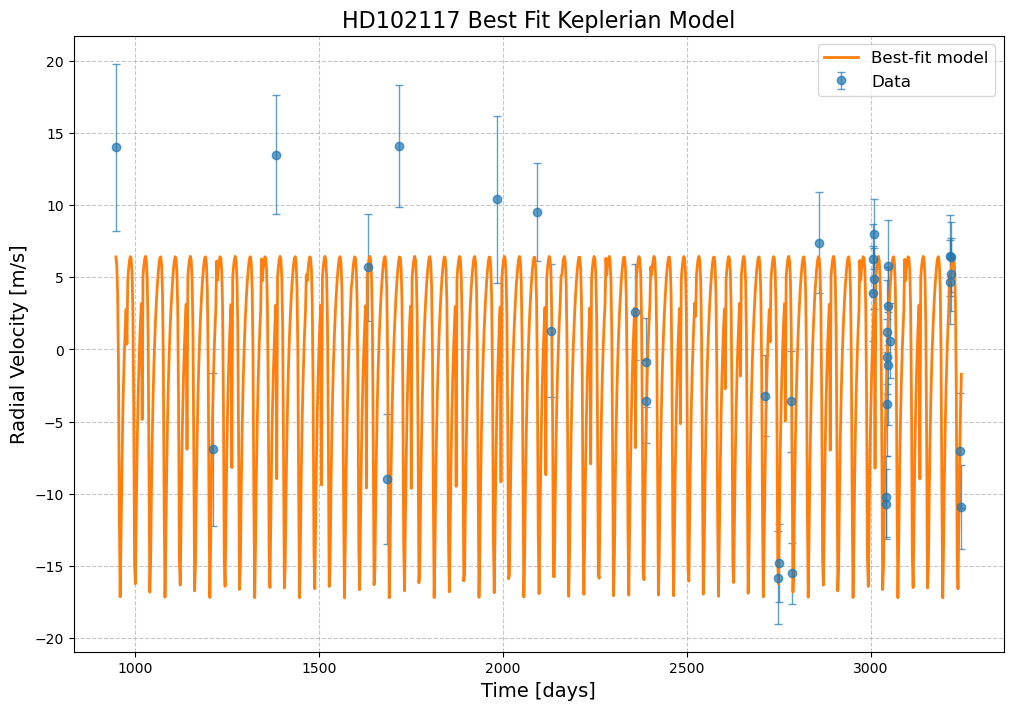

In [11]:
stars_best_fit = {} # star with the best fit

def M_sinI(P, K, M_star, e): #to caluate the minimum mass of planet. Should come out ass mass of jupiter.
    G = astropy.constants.G
    P = (P * astropy.units.day).to(astropy.units.s)
    K = K * (astropy.units.m / astropy.units.s)
    M_star = M_star.to(astropy.units.kg)
    msinI = K * (P / (2 * np.pi * G))**(1/3) * (1 - e**2)**(1/2) * M_star**(2/3)
    return msinI.to(astropy.units.M_jup)


def residuals(theta, t, y, yerr): #residuals.
    model = Keplerian_model(theta, t)
    return (y - model)**2 / yerr**2  # Returns residuals for each point


# Define the initial guess for the parameters
# V, K, P, e, tau, omega
for star in stars:
    Time = stars[star]['Time']
    Radial_Velocity = stars[star]['Radial Velocity']
    Uncertainty = stars[star]['Uncertainty']
    
    LS = LombScargle(Time, Radial_Velocity, Uncertainty, nterms=1) #LS model
    auto_frequency = LS.autofrequency()
    automatic_periodogram = LS.power(auto_frequency)
    best_frequency = auto_frequency[np.argmax(automatic_periodogram)]
    best_period = 1 / best_frequency
    
    theta = LS.model_parameters(best_frequency).value #Theta parameter
    phase = (Time % best_period) / best_period
    
    # Initial parameter estimates
    tau = Time[np.argmax(Radial_Velocity)]
    K = np.sqrt(theta[1]**2 + theta[2]**2)
    P = best_period 
    omega = np.pi/2
    e = 0.08
    V = theta[0] - (K * e * np.cos(omega))
    
    initial_guess = [V, K, P.value, e, tau, omega]
    bounds = ([-150, 1, 0.0001, 1e-2, 1e-1, -3e-1], [150, 1e3, 3e5, 0.9, 5e7, 2*np.pi])#some reasonable bounds.... 
    
    # Perform least-squares optimization
    result = least_squares(residuals, initial_guess, args=(Time, Radial_Velocity, Uncertainty), bounds=bounds) 
    
    # Extract best-fit parameters
    best_fit_params = result.x
    V, K, P, e, tau, omega = best_fit_params
    Evaluation = {}
    Evaluation['Best Fit Parameters'] = best_fit_params
    # Calculate Msini
    M_sino = M_sinI(P, K, stellar_masses[star], e)
    print(f"Best-fit parameters:\nV = {V}\nK = {K}\nP = {P}\ne = {e}\ntau = {tau}\nomega = {omega}")
    print(f"Msini = {M_sino:.2f}")
    
    # Plotting the data and best-fit model
    t_fit = np.linspace(min(Time), max(Time), 1000)
    v_fit = Keplerian_model(best_fit_params, t_fit)
    Evaluation['Time'] = t_fit
    Evaluation['Radial Velocity'] = v_fit
    Evaluation['MsinI'] = M_sino
    stars_best_fit[star] = Evaluation
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.errorbar(Time, Radial_Velocity, yerr=Uncertainty, fmt='o', elinewidth=1, capsize=3, label='Data', color='tab:blue', alpha=0.7)
    ax.plot(t_fit, v_fit, label='Best-fit model', color='tab:orange', linewidth=2)
    ax.set_xlabel('Time [days]', fontsize=14)
    ax.set_ylabel('Radial Velocity [m/s]', fontsize=14)
    ax.set_title(f'{star} Best Fit Keplerian Model', fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    



Finally, obtain an estimate for the uncertainty on the parameters $\vec\theta$. 
There are several ways to do this; the easiest may be
by Monte-Carlo simulation of synthetic data-sets.
Generate $N$ synthetic data-sets by taking your best-fit RV curve $v(t_i|\vec{\theta})$
and adding Gaussian noise at each observed time, creating new RV data-sets
$v_i^{(j)} = v(t_i|\vec{\theta}) + \mathrm{err}_i^{(j)}$, where $\mathrm{err}_i ~ N(0,\sigma_i)$.
Then find new fits $\vec{\theta}^{(j)}$ for each synthetic data-set. Take the covariance
of the $N$ sets of parameters as an estimate of the uncertainty on your 
parameter values. Have you shown that the planet's eccentricity and 
$m\sin I$ are significantly different from zero?

I do what is described above with the help of job lib and running the MC simulation $10^4$ times. Instead of taking covarience because that assumes a distribution to be gaussian. I take the distribution and find the 16th and 84th percentile limits and present them as the 68 percent confidence interval. Less assumptions leads to less systematic bias (I think).  

In [546]:
from joblib import Parallel, delayed
star_statistics = {} #where I save the star stats for distribution plot in the cell below. 
for star in stars_best_fit:
    
    monte_carlo_range = int(1e4)
    
    Theta=[] 
    Distribution={}
    time = stars_best_fit[star]['Time']
    radial = stars_best_fit[star]['Radial Velocity']
    
    Observed_time = stars[star]['Time']
    Observed_radial = stars[star]['Radial Velocity']
    Observed_uncertainty = stars[star]['Uncertainty']
    
    interpolated= interp1d(time, radial, kind='linear')(Observed_time) #interpolating to add gaussian noise.
    
    LS = LombScargle(Observed_time, Observed_radial, Observed_uncertainty, nterms=1)
    
    auto_frequency = LS.autofrequency()
    automatic_periodogram = LS.power(auto_frequency)
    best_frequency = auto_frequency[np.argmax(automatic_periodogram)]
    best_period = 1 / best_frequency
    
    theta = LS.model_parameters(best_frequency).value
    phase = (Observed_time % best_period) / best_period
    
    # Initial parameter estimates
    tau = Observed_time[np.argmax(Observed_radial)]
    K = np.sqrt(theta[1]**2 + theta[2]**2)
    P = best_period
    omega = 0.6
    e = 0.2
    V = theta[0] - (K * e * np.cos(omega))
    
    # Prepare initial guess and bounds
    initial_guess = [V, K, P.value, e, tau, omega]
    bounds = ([-150, 1, 0.0001, 1e-2, 1e-1, -3e-1], [150, 1e3, 3e5, 0.9, 5e7, 2*np.pi])

    def monte_carlo_iteration(): #Generatesynthetic RV data 
        # adding Gaussian noise to the baseline
        New_RV = interpolated + np.random.normal(0, Observed_uncertainty)
        # Perform least-squares optimization on synthetic data
        results = least_squares(residuals, initial_guess, args=(Observed_time, New_RV, Observed_uncertainty), bounds=bounds)
        return results.x

    # Run Monte Carlo simulations in parallel
    Theta = Parallel(n_jobs=-1)(delayed(monte_carlo_iteration)() for _ in tqdm(range(monte_carlo_range))) #ran everything parrallel cause it is long if serial
    Theta = np.array(Theta)
    #save the parameters on the Distribution dictionary.
    Distribution['V'] = Theta[:, 0] 
    Distribution['K'] = Theta[:, 1]
    Distribution['P'] = Theta[:, 2]
    Distribution['e'] = Theta[:, 3]
    Distribution['tau'] = Theta[:, 4]
    Distribution['omega'] = Theta[:, 5]
    
    Distribution['M_distribution']  = np.array([M_sinI(P, K, stellar_masses[star], e).value for K, P, e in Theta[:, 1:4]]) #calculate the M_sini
    #save the distribution into a bigger dictionary.
    star_statistics[star] = Distribution


100%|██████████| 10000/10000 [08:10<00:00, 20.39it/s]


In [38]:
def fun(key): #this just makes it so that i can for loop the dictionary and get the correct x label
    if key=='V':
        return r"Systematic Velocity ($V$) [m/s]"
    if key=='K':
        return r'Amplitude ($K$) [m/s]'
    if key=='P':
        return r'Period ($P$) [days]'
    if key=='e':
        return r'Eccentricity ($e$)'
    if key=='tau':
        return r'Time of Periastron Passage ($\tau$) [days]'
    if key=='omega':
        return r'Argument of Periastron ($\omega$) [rad]'
    if key=='M_distribution':
        return r'Mass minimum ($M_i\sin(I)$) [$M_{Jup}$]'


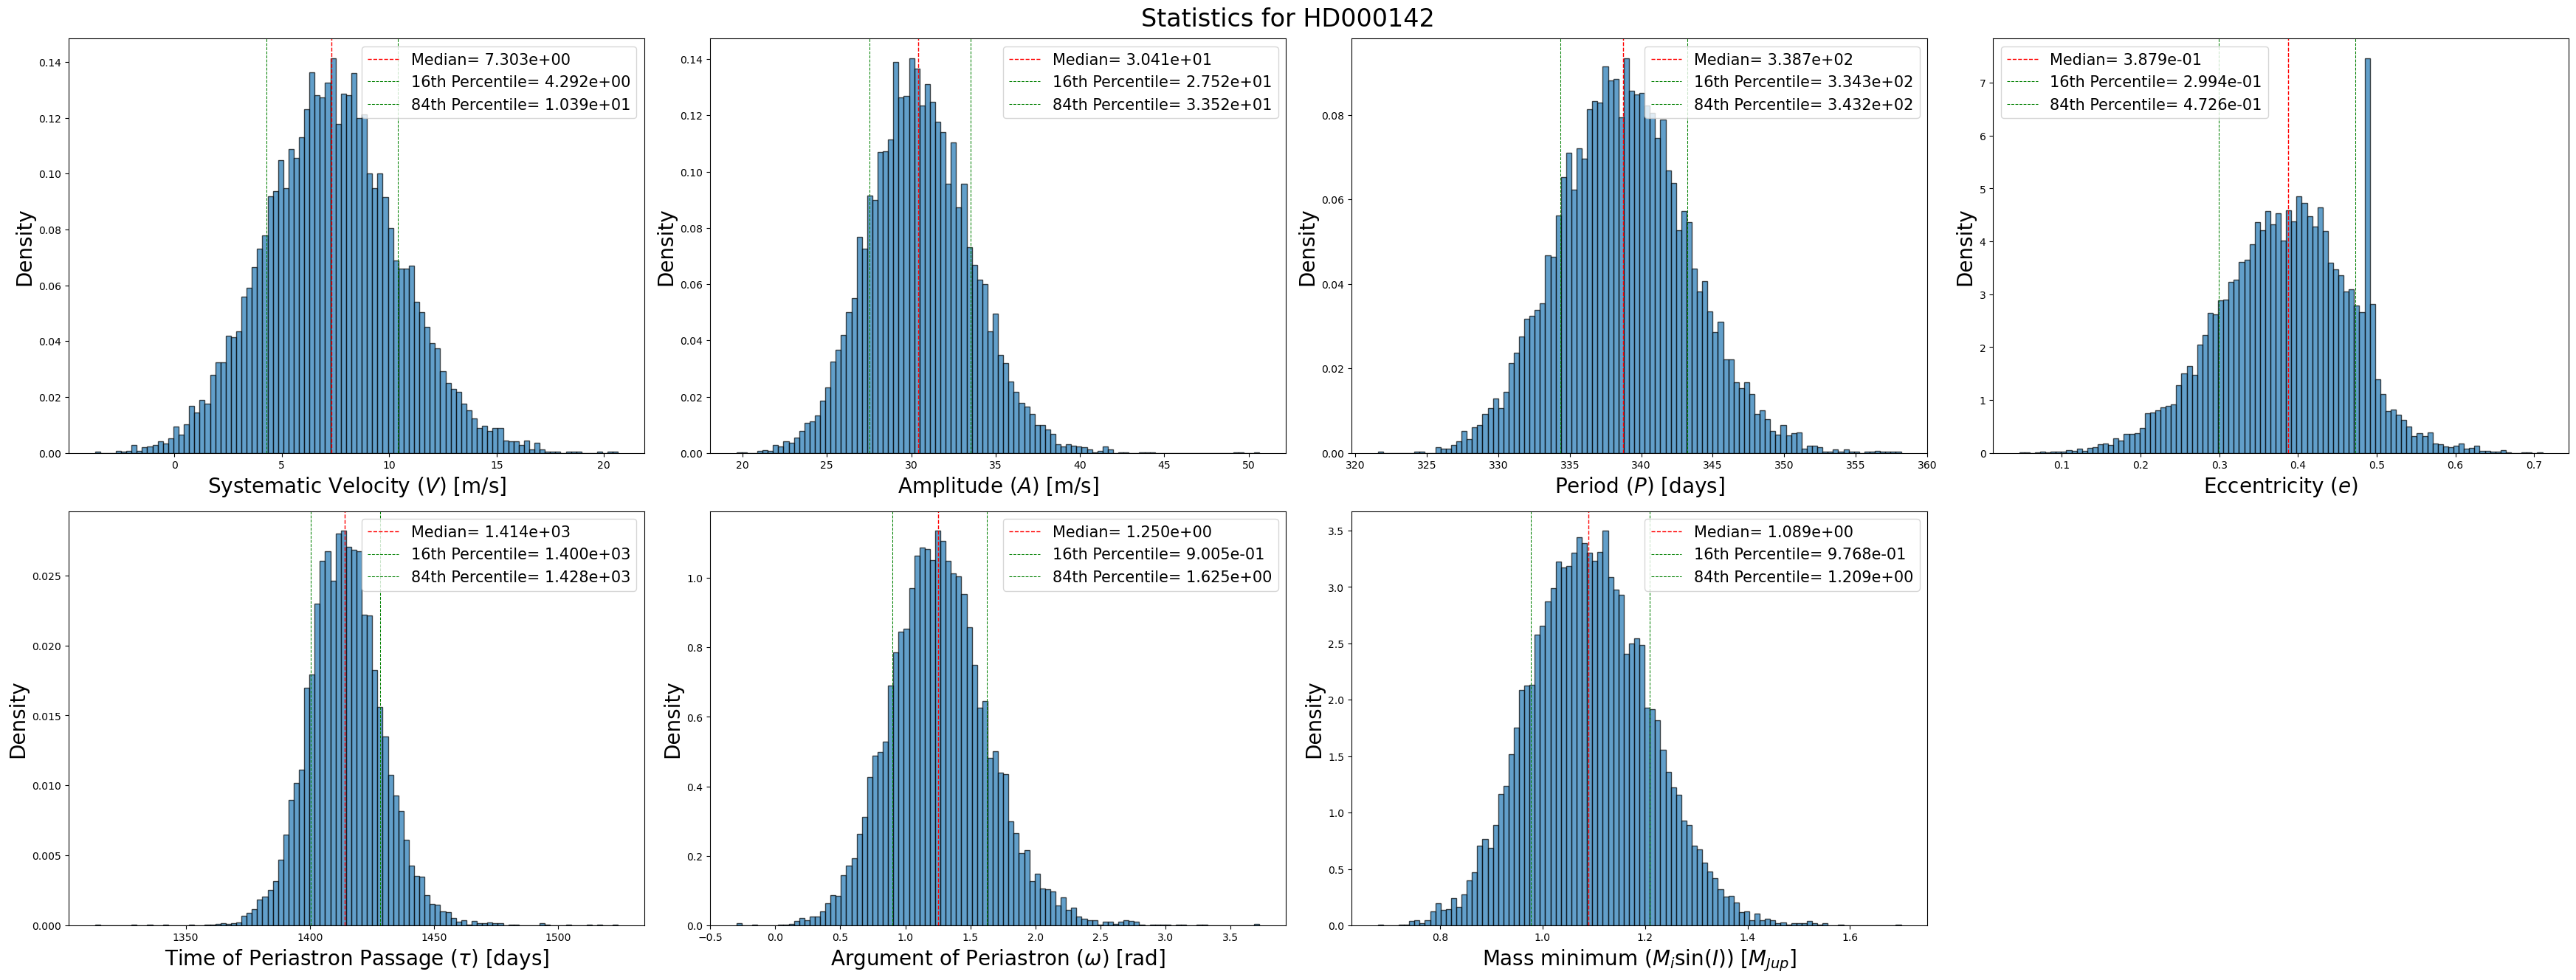

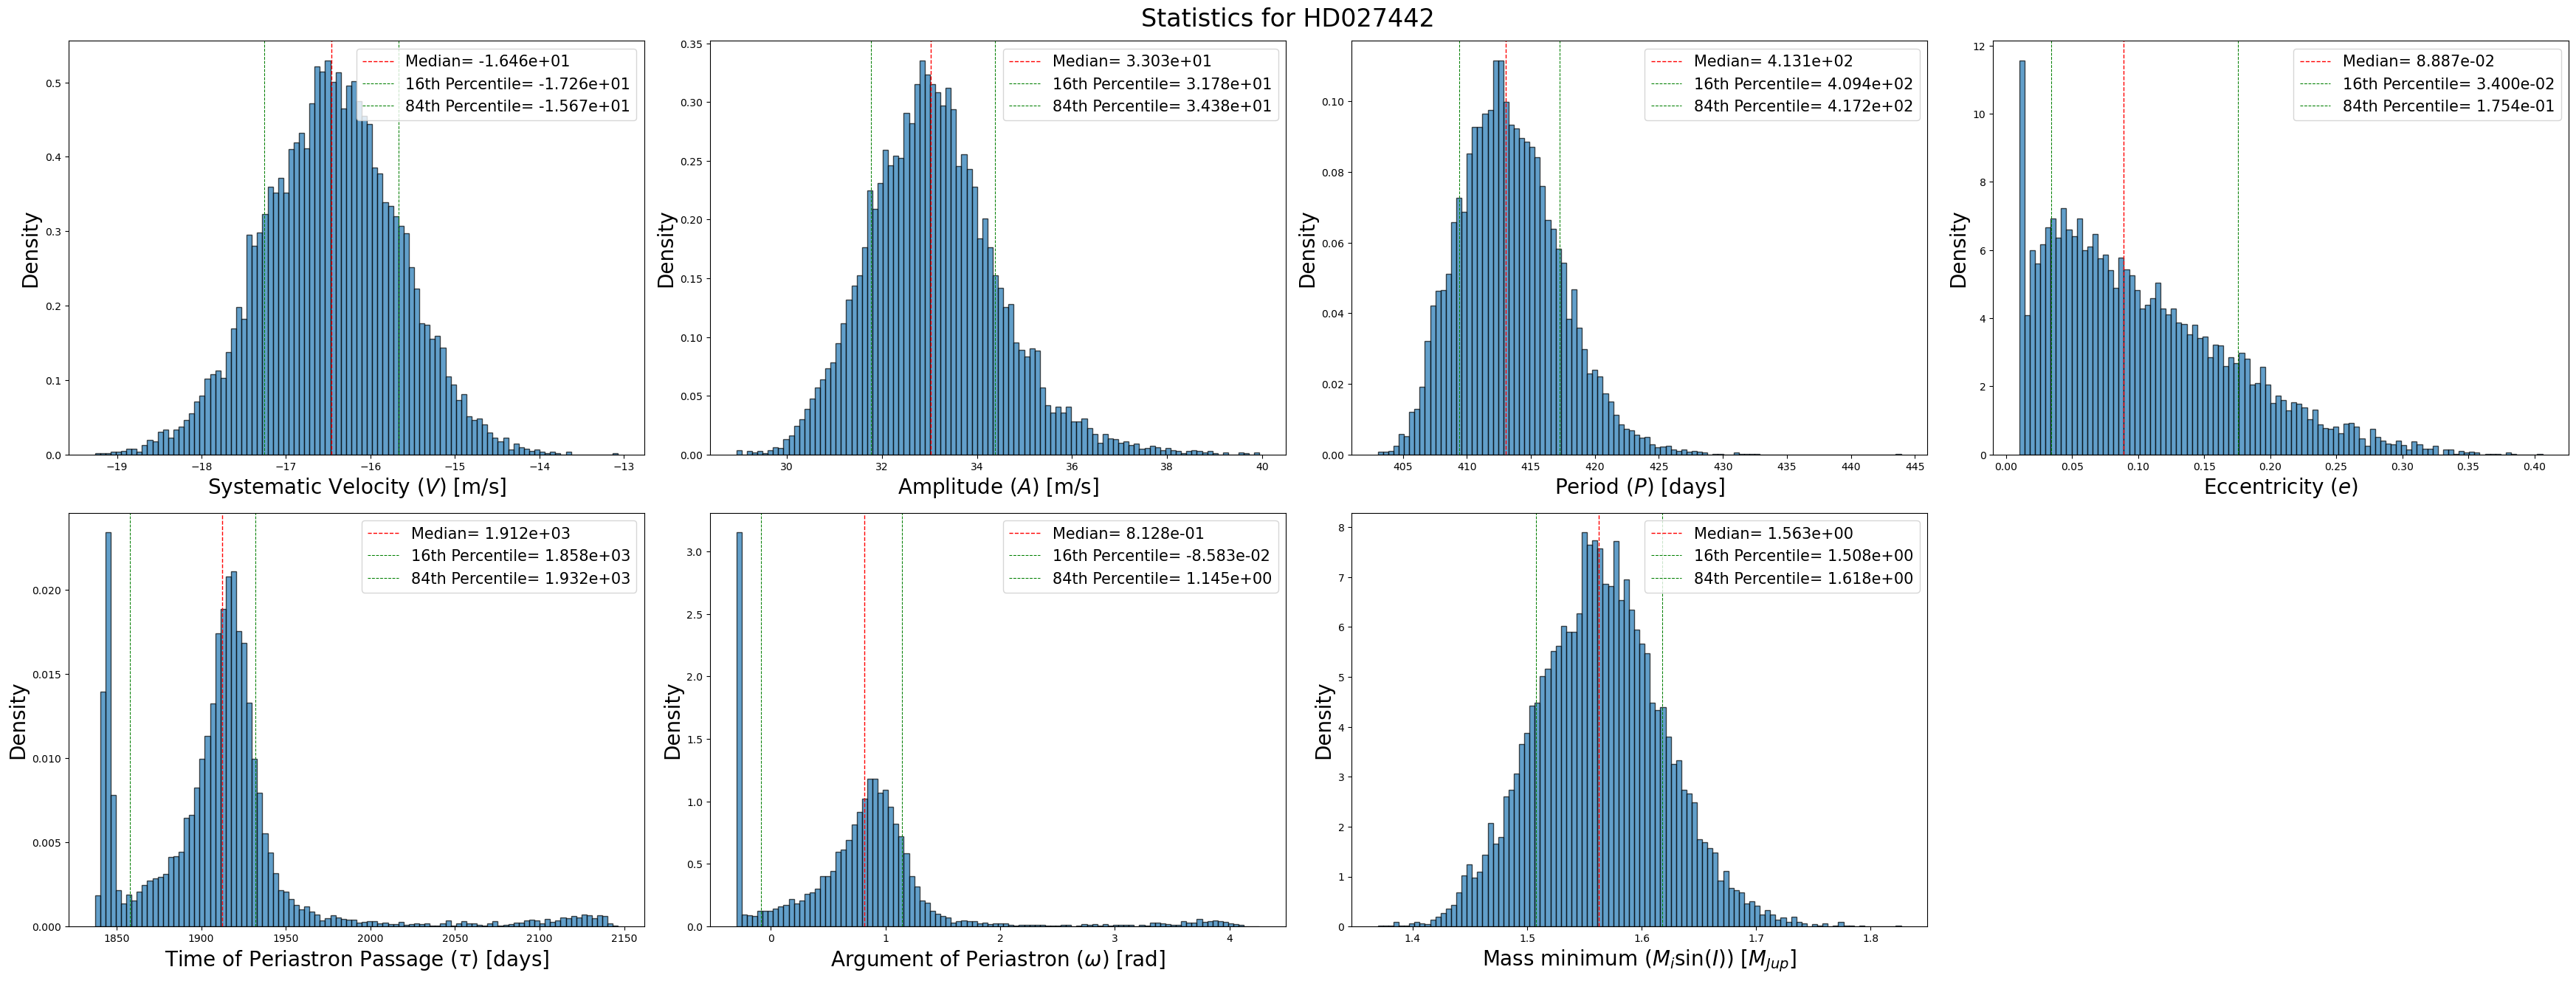

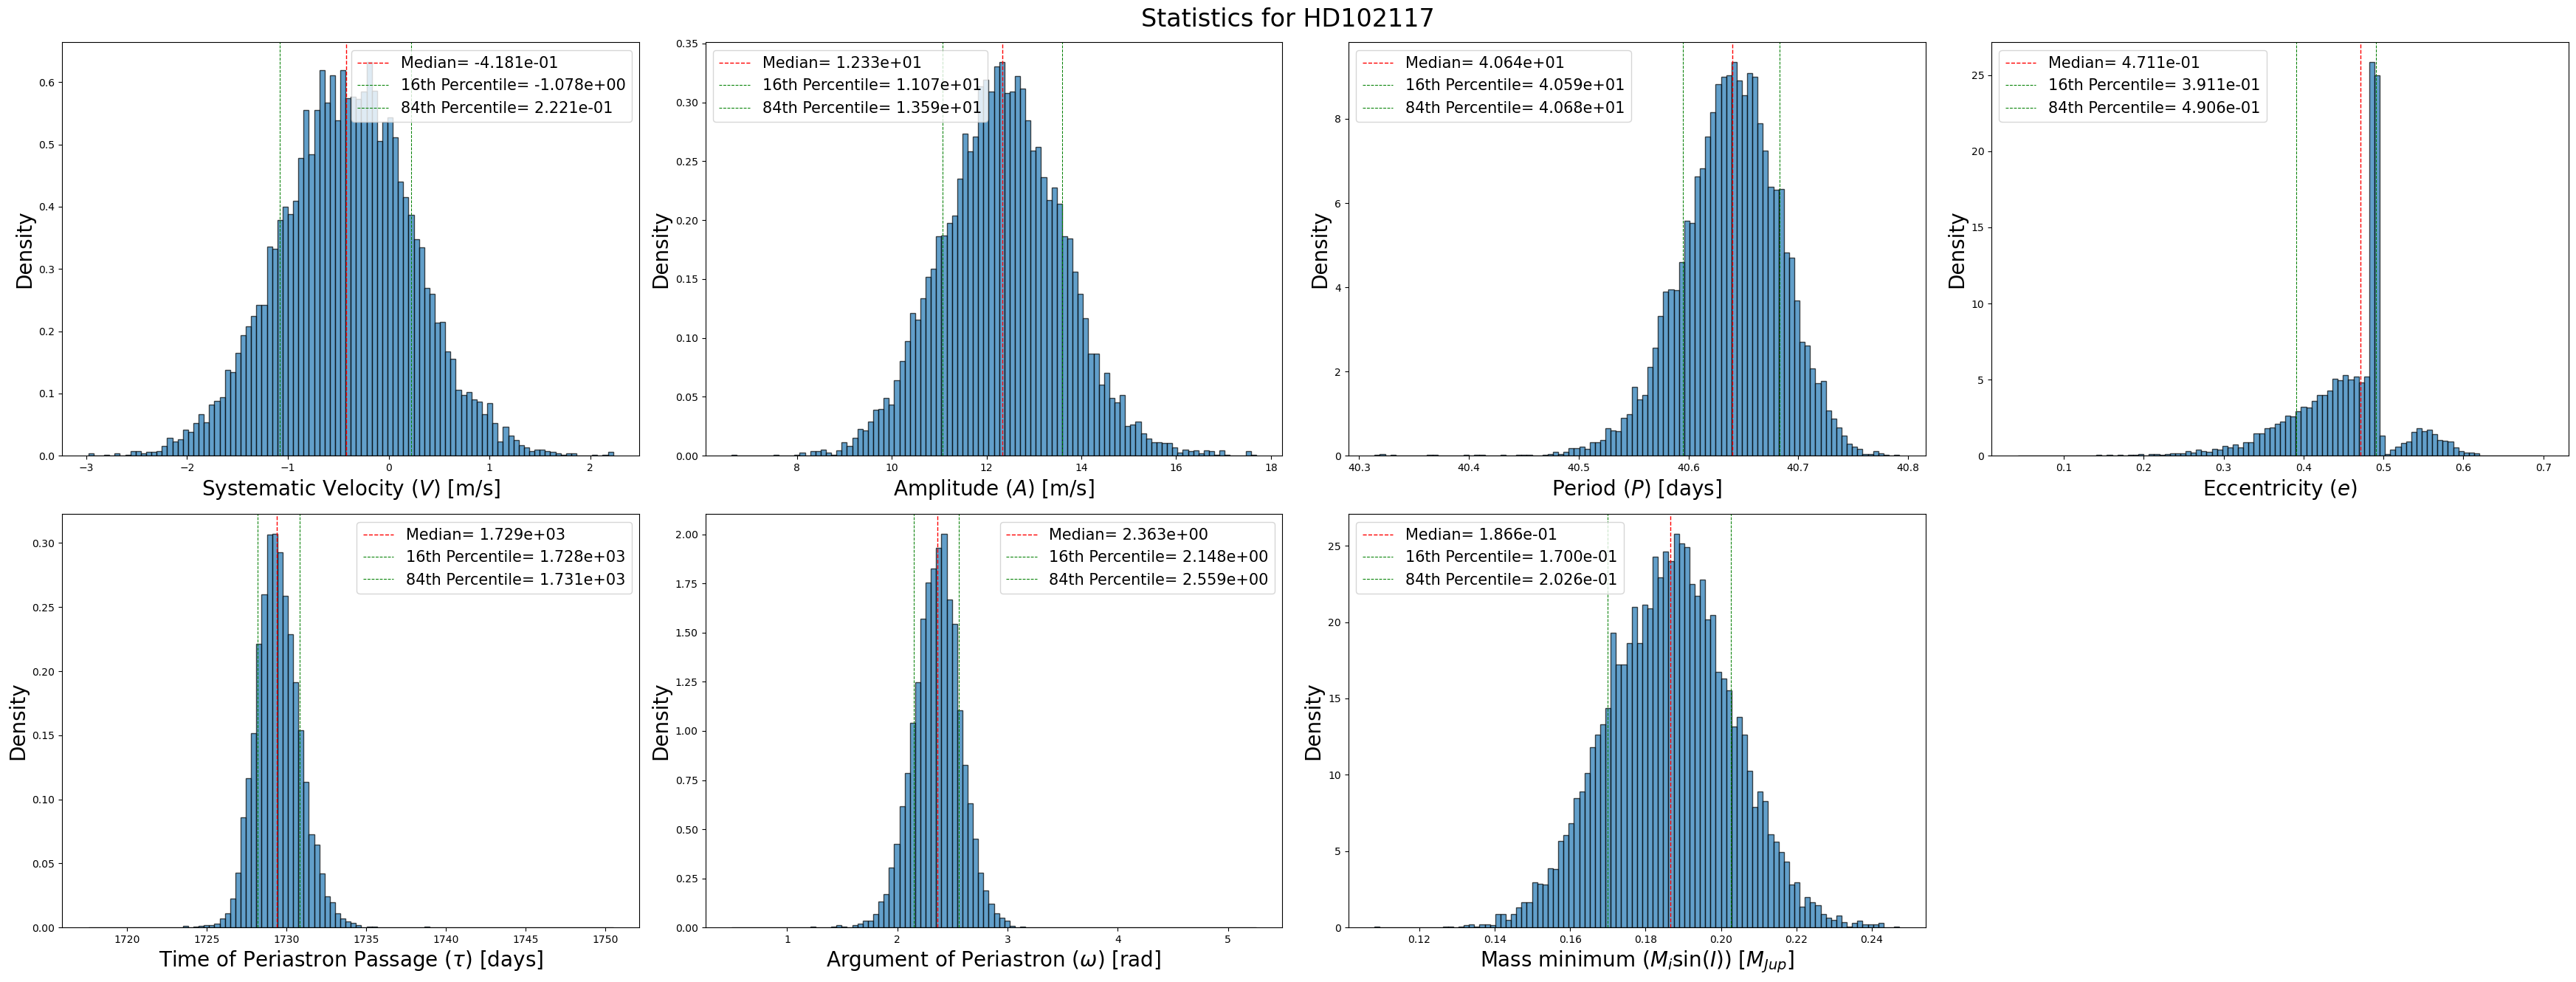

In [37]:
for star in star_statistics:
    fig = plt.figure(figsize=(35, 20))
    for i, key in enumerate(star_statistics[star].keys()):
        ax = fig.add_subplot(3, 4, i+1)
        ax.hist(star_statistics[star][key], bins=100, density=True, alpha=0.7, color='tab:blue', edgecolor='black', linewidth=1)
        ax.set_xlabel(fun(key),fontsize=20)
        ax.set_ylabel('Density',fontsize=20)
        #median
        ax.axvline(np.nanmedian(star_statistics[star][key]), color='red', linestyle='--', label='Median= '+f'{np.median(star_statistics[star][key]):.3e}', lw=1)
        #16th percentile
        ax.axvline(np.percentile(star_statistics[star][key], 16), color='green', linestyle='--', label='16th Percentile= '+f'{np.percentile(star_statistics[star][key], 16):.3e}', lw=0.75)
        #84th percentile
        ax.axvline(np.percentile(star_statistics[star][key], 84), color='green', linestyle='--', label='84th Percentile= '+f'{np.percentile(star_statistics[star][key], 84):.3e}', lw=0.75)
        ax.legend(fontsize=15)
    
    fig.suptitle(f'Statistics for {star}', fontsize=24) 
    plt.tight_layout(rect=[0, 0.03, 1, 0.99]) 



It is to be noted that the time of periastron passage is consistently underestimated for all the exoplanets. HD00142 MC simulation provided the wrong value for $\omega$ and $\tau$. They were underestimated. HD27442 had the same issue as HD000142 with $\tau$ underestimated by several orders and $\omega$ being too low. Finally HD1021117 had more than 2 parameters wrong. The eccentricity was overestimated, Period was double the true value, as well as the $\tau$ and $\omega$ being underestimated.  Interestingly, the minimum mass all match the literature values. So i suspect a degeneracy of parameters for a given mass minimum value. I have not been able to identify why $\tau$ was underestimated by several orders. All the above $m\sin(I)$ is significantly different from 0 M_jup because the 99% confidence interval does not contain 0 M_jup.

Non linear Least square fitting tends to converge at local minimums rather than the global minimum and therefore you get the density spikes in the above distribution. Which is highly sensitive to initial conditions. If the initial parameters are biased or poor, which was the case when HD102117 calculated it's initial eccentricity and P value directly from LS power diagram. It was the wrong fit. So if the initial conditions are biased we will not nessacerily get the correct convergence. Monte-Carlo Simulation does a sort of resampling on the synthetic model. But if our model was wrong from the beginning we will NOT get correct synthetic data to fit LS ontop of. Perhaps performing MCMC which allows walkers to explore the parameter space and "Forget" the initial conditions would be better than the correct method. Finally  HD1021117 had three exoplanets, so the assumption of $M=1$ is wrong and more terms need to be included into LS object. So our model assumption was wrong from the start. Further more, HD027442 has a binary star component. Perhaps we could change the $M=2$ to solve this issue. But as decribed above, There are many suggestion to keep in mind when working with least square minimization and the Monte carlo simulations. 

All information regarding the exoplanets are obtained from https://exoplanetarchive.ipac.caltech.edu/

# Disclaimer


I used ChatGPT to optimize the joblib library and to speed up my code. No writing AI was used to write text. My group works for part 1 on a common colab and continued to not colab after on code, but just to compare results. I had copilot on to autofill the rest of the code I would have written. It is for predicting my next 'Move'